In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm

from modules import *
from networks import *
from training import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
size = 256
transform = A.Compose([
    A.Resize(height=size, width=size, interpolation=cv.INTER_AREA),
    A.Lambda(image=sharpen, p=1.0),
    A.Lambda(image=polar_transform, mask=polar_transform),
    A.Normalize(),
    ToTensorV2(),
])

In [3]:
best_model_path = "../models/polar/ref/dual.pth"
checkpoint = load_checkpoint(best_model_path, map_location=device)
model = checkpoint['model']
model = model.eval()

=> Loading checkpoint: ../models/polar/ref/dual.pth


In [4]:
def load_origa_dataframe():
    origa_df = pd.read_excel('../data/ORIGA/labels.xlsx')
    origa_df['filename'] = origa_df['filename'].str.strip().str.strip("'")
    origa_df = origa_df.rename(columns={'diagnosis(glaucoma=True)': 'glaucoma'})
    origa_df = origa_df[['filename', 'glaucoma']]
    origa_df = origa_df.dropna()
    return origa_df


def load_drishti_dataframe():
    drishti_df = pd.read_excel('../data/DRISHTI/Drishti-GS1_files/Drishti-GS1_diagnosis.xlsx')
    drishti_df = drishti_df.rename(columns={'Unnamed: 1': 'filename', 'Unnamed: 8': 'glaucoma'})
    drishti_df['filename'] = drishti_df['filename'].str.strip().str.strip("'")
    drishti_df['glaucoma'] = drishti_df['glaucoma'].map({'Glaucomatous': True, 'Normal': False})
    drishti_df = drishti_df[['filename', 'glaucoma']]
    drishti_df = drishti_df.dropna()
    return drishti_df

In [ ]:
def generate_dataframe(images_root: str, masks_root: str):
    image_paths = load_files_from_dir(images_root)
    mask_paths = load_files_from_dir(masks_root)
    df = load_origa_dataframe() if 'ORIGA' in images_root else load_drishti_dataframe()

    rows = []
    for image_path, mask_path in zip(tqdm(image_paths), mask_paths):
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        mask = cv.resize(mask, (size, size), interpolation=cv.INTER_AREA)

        real_vcdr = calculate_vCDR(mask)
        real_hcdr = calculate_hCDR(mask)
        real_acdr = calculate_aCDR(mask)
        real_disc_height = calculate_disc_height(mask)
        real_disc_width = calculate_disc_width(mask)
        real_disc_area = calculate_disc_area(mask)
        read_cup_height = calculate_cup_height(mask)
        real_cup_width = calculate_cup_width(mask)
        real_cup_area = calculate_cup_area(mask)

        augmented = transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

        images = image.unsqueeze(0).to(device)
        masks = mask.unsqueeze(0).to(device)

        prediction, *_ = predict(
            'dual', model, images, masks, device=device,
            od_thresh=0.20, oc_thresh=0.25, post_process_fn=postprocess,
        )

        prediction = prediction.cpu().numpy().astype(np.uint8)
        prediction = polar_to_cartesian(prediction)[0]

        pred_vcdr = calculate_vCDR(prediction)
        pred_hcdr = calculate_hCDR(prediction)
        pred_acdr = calculate_aCDR(prediction)
        pred_disc_height = calculate_disc_height(prediction)
        pred_disc_width = calculate_disc_width(prediction)
        pred_disc_area = calculate_disc_area(prediction)
        pred_cup_height = calculate_cup_height(prediction)
        pred_cup_width = calculate_cup_width(prediction)
        pred_cup_area = calculate_cup_area(prediction)

        subset = f'{"origa" if "ORIGA" in image_path else "drishti"}_{"train" if "Train" in image_path else "test"}'
        row = df[df['filename'].str.contains(Path(image_path).stem)]
        assert len(row) == 1, f"Found {len(row)} rows for {image_path}"

        rows.append({
            'image': image_path,
            'mask': mask_path,
            'set': subset,
            'glaucoma': row['glaucoma'].values[0],
            'real_vcdr': real_vcdr,
            'pred_vcdr': pred_vcdr,
            'real_hcdr': real_hcdr,
            'pred_hcdr': pred_hcdr,
            'real_acdr': real_acdr,
            'pred_acdr': pred_acdr,
            'real_disc_height': real_disc_height,
            'pred_disc_height': pred_disc_height,
            'real_disc_width': real_disc_width,
            'pred_disc_width': pred_disc_width,
            'real_disc_area': real_disc_area,
            'pred_disc_area': pred_disc_area,
            'real_cup_height': read_cup_height,
            'pred_cup_height': pred_cup_height,
            'real_cup_width': real_cup_width,
            'pred_cup_width': pred_cup_width,
            'real_cup_area': real_cup_area,
            'pred_cup_area': pred_cup_area,
        })

    return pd.DataFrame(rows)


origa_train_df = generate_dataframe('../data/ORIGA/ROI/TrainImages', '../data/ORIGA/ROI/TrainMasks')
origa_test_df = generate_dataframe('../data/ORIGA/ROI/TestImages', '../data/ORIGA/ROI/TestMasks')
drishti_train_df = generate_dataframe('../data/DRISHTI/ROI/TrainImages', '../data/DRISHTI/ROI/TrainMasks')
drishti_test_df = generate_dataframe('../data/DRISHTI/ROI/TestImages', '../data/DRISHTI/ROI/TestMasks')

In [6]:
df = pd.concat([
    origa_train_df,
    origa_test_df,
    drishti_train_df,
    drishti_test_df,
])
df.to_csv('../data/cdr-results.csv', index=False)
df

,image,mask,set,glaucoma,real_vcdr,pred_vcdr,real_hcdr,pred_hcdr,real_acdr,pred_acdr,...,real_disc_width,pred_disc_width,real_disc_area,pred_disc_area,real_cup_height,pred_cup_height,real_cup_width,pred_cup_width,real_cup_area,pred_cup_area
0,../data/ORIGA/ROI/TrainImages/001.jpg,../data/ORIGA/ROI/TrainMasks/001.png,origa_train,False,0.718121,0.691781,0.672131,0.752066,0.477580,0.497225,...,122,121,14295,13873,107,101,82,91,6827,6898
1,../data/ORIGA/ROI/TrainImages/002.jpg,../data/ORIGA/ROI/TrainMasks/002.png,origa_train,False,0.693431,0.652482,0.709091,0.672566,0.495605,0.435235,...,110,113,11717,12885,95,92,78,76,5807,5608
2,../data/ORIGA/ROI/TrainImages/003.jpg,../data/ORIGA/ROI/TrainMasks/003.png,origa_train,False,0.957447,0.780000,0.948529,0.734568,0.915019,0.574863,...,136,162,14921,16844,135,117,129,119,13653,9683
3,../data/ORIGA/ROI/TrainImages/004.jpg,../data/ORIGA/ROI/TrainMasks/004.png,origa_train,False,0.727891,0.659574,0.713178,0.707692,0.517543,0.447831,...,129,130,14764,14108,107,93,92,92,7641,6318
4,../data/ORIGA/ROI/TrainImages/005.jpg,../data/ORIGA/ROI/TrainMasks/005.png,origa_train,False,0.613445,0.658333,0.730435,0.732759,0.453153,0.464582,...,115,116,10705,10842,73,79,84,85,4851,5037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,../data/DRISHTI/ROI/TestImages/drishtiGS_095.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_095.png,drishti_test,False,0.507576,0.569231,0.488189,0.622951,0.237890,0.341940,...,127,122,12964,12239,67,74,62,76,3084,4185
47,../data/DRISHTI/ROI/TestImages/drishtiGS_096.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_096.png,drishti_test,False,0.513699,0.543750,0.460432,0.611111,0.233628,0.332656,...,139,144,15820,17228,75,87,64,88,3696,5731
48,../data/DRISHTI/ROI/TestImages/drishtiGS_097.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_097.png,drishti_test,False,0.525424,0.694611,0.573171,0.656627,0.299821,0.448626,...,164,166,22907,20779,93,116,94,109,6868,9322
49,../data/DRISHTI/ROI/TestImages/drishtiGS_099.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_099.png,drishti_test,False,0.623288,0.717105,0.627737,0.732394,0.395119,0.500554,...,137,142,15613,16260,91,109,86,104,6169,8139


In [7]:
df = pd.read_csv('../data/cdr-results.csv')
df_train = df[~(df['set'].str.contains('test') & df['set'].str.contains('drishti'))]
df_test = df[df['set'].str.contains('test') & df['set'].str.contains('drishti')]
print(f'Train: {len(df_train)} | Test: {len(df_test)} | Total: {len(df)}')
df

Train: 700 | Test: 51 | Total: 751


,image,mask,set,glaucoma,real_vcdr,pred_vcdr,real_hcdr,pred_hcdr,real_acdr,pred_acdr,...,real_disc_width,pred_disc_width,real_disc_area,pred_disc_area,real_cup_height,pred_cup_height,real_cup_width,pred_cup_width,real_cup_area,pred_cup_area
0,../data/ORIGA/ROI/TrainImages/001.jpg,../data/ORIGA/ROI/TrainMasks/001.png,origa_train,False,0.718121,0.691781,0.672131,0.752066,0.477580,0.497225,...,122,121,14295,13873,107,101,82,91,6827,6898
1,../data/ORIGA/ROI/TrainImages/002.jpg,../data/ORIGA/ROI/TrainMasks/002.png,origa_train,False,0.693431,0.652482,0.709091,0.672566,0.495605,0.435235,...,110,113,11717,12885,95,92,78,76,5807,5608
2,../data/ORIGA/ROI/TrainImages/003.jpg,../data/ORIGA/ROI/TrainMasks/003.png,origa_train,False,0.957447,0.780000,0.948529,0.734568,0.915019,0.574863,...,136,162,14921,16844,135,117,129,119,13653,9683
3,../data/ORIGA/ROI/TrainImages/004.jpg,../data/ORIGA/ROI/TrainMasks/004.png,origa_train,False,0.727891,0.659574,0.713178,0.707692,0.517543,0.447831,...,129,130,14764,14108,107,93,92,92,7641,6318
4,../data/ORIGA/ROI/TrainImages/005.jpg,../data/ORIGA/ROI/TrainMasks/005.png,origa_train,False,0.613445,0.658333,0.730435,0.732759,0.453153,0.464582,...,115,116,10705,10842,73,79,84,85,4851,5037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,../data/DRISHTI/ROI/TestImages/drishtiGS_095.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_095.png,drishti_test,False,0.507576,0.569231,0.488189,0.622951,0.237890,0.341940,...,127,122,12964,12239,67,74,62,76,3084,4185
747,../data/DRISHTI/ROI/TestImages/drishtiGS_096.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_096.png,drishti_test,False,0.513699,0.543750,0.460432,0.611111,0.233628,0.332656,...,139,144,15820,17228,75,87,64,88,3696,5731
748,../data/DRISHTI/ROI/TestImages/drishtiGS_097.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_097.png,drishti_test,False,0.525424,0.694611,0.573171,0.656627,0.299821,0.448626,...,164,166,22907,20779,93,116,94,109,6868,9322
749,../data/DRISHTI/ROI/TestImages/drishtiGS_099.png,../data/DRISHTI/ROI/TestMasks/drishtiGS_099.png,drishti_test,False,0.623288,0.717105,0.627737,0.732394,0.395119,0.500554,...,137,142,15613,16260,91,109,86,104,6169,8139


MAE: 0.056858510755133373
MSE: 0.005790485339279575
R^2: 0.660145283330717


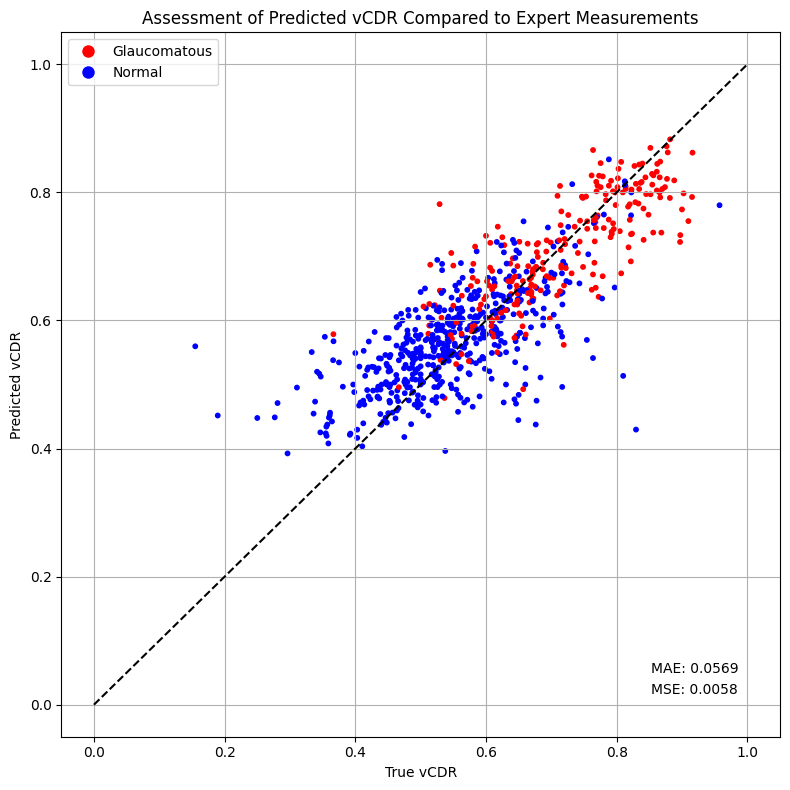

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def plot_regression(true, pred, labels, title, xlabel, ylabel):
    print('MAE:', mean_absolute_error(true, pred))
    print('MSE:', mean_squared_error(true, pred))
    print('R^2:', r2_score(true, pred))

    colors = labels.map({True: 'red', False: 'blue'})
    maximum = max(true.max(), pred.max(), 1)

    plt.figure(figsize=(8, 8))
    plt.scatter(true, pred, c=colors, s=10, label=glaucoma.map({True: 'Glaucoma', False: 'Non-Glaucoma'}))
    plt.plot([0, maximum], [0, maximum], '--k')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Glaucomatous', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=10),
    ])
    plt.tight_layout()
    plt.text(0.82, 0.09, f'MAE: {mean_absolute_error(true, pred):.4f}', transform=plt.gca().transAxes)
    plt.text(0.82, 0.06, f'MSE: {mean_squared_error(true, pred):.4f}', transform=plt.gca().transAxes)
    plt.show()


true = df['real_vcdr']
pred = df['pred_vcdr']
glaucoma = df['glaucoma']

plot_regression(
    true, pred, glaucoma,
    'Assessment of Predicted vCDR Compared to Expert Measurements',
    'True vCDR', 'Predicted vCDR',
)

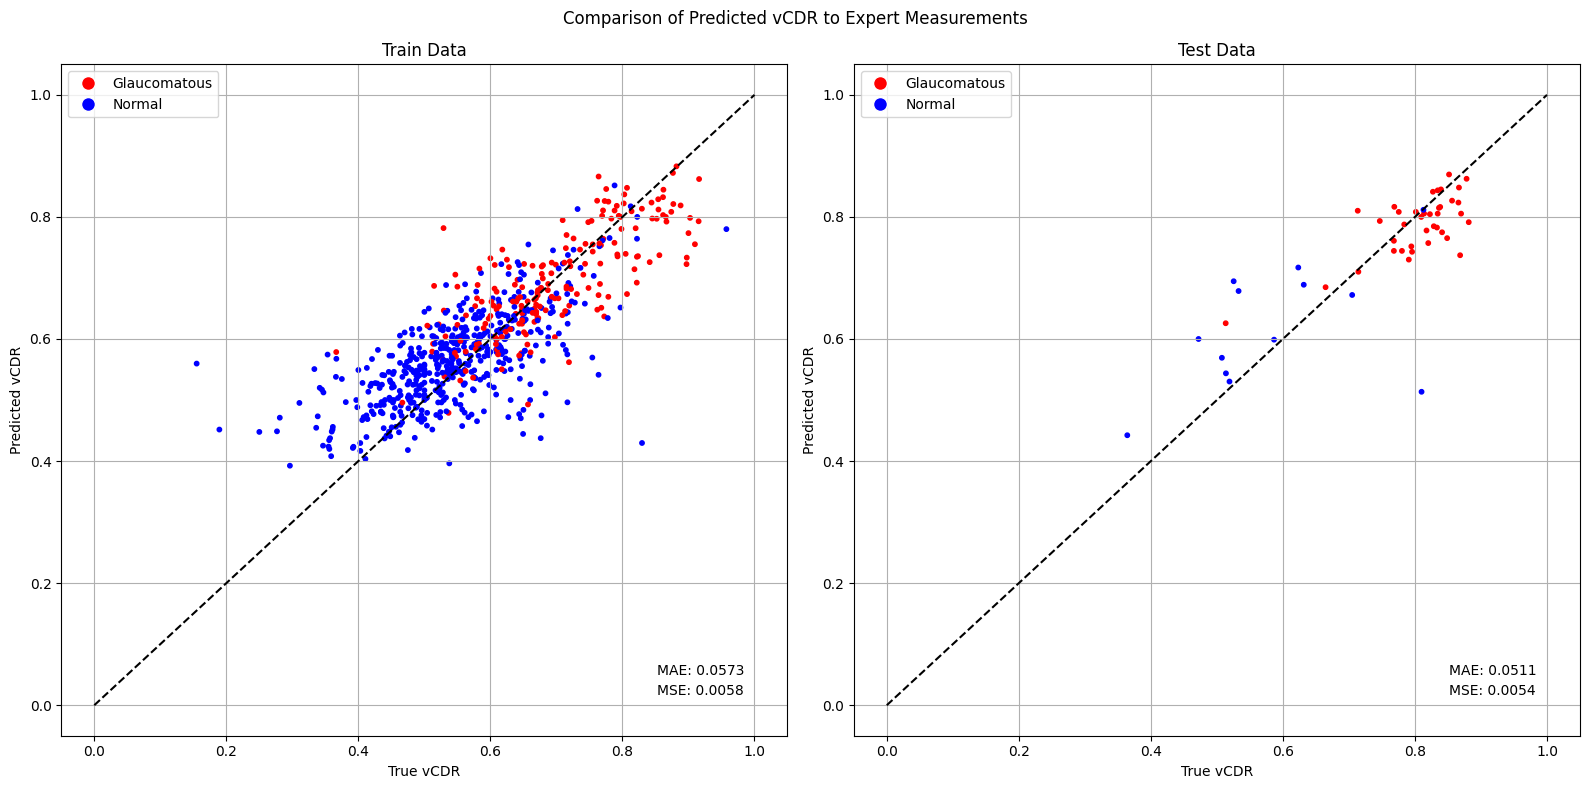

In [9]:
# Same plot but side by side with train and test data
true_train = df_train['real_vcdr']
pred_train = df_train['pred_vcdr']
glaucoma_train = df_train['glaucoma']

true_test = df_test['real_vcdr']
pred_test = df_test['pred_vcdr']
glaucoma_test = df_test['glaucoma']

_, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, true, pred, glaucoma, title in zip(
        axes,
        [true_train, true_test],
        [pred_train, pred_test],
        [glaucoma_train, glaucoma_test],
        ['Train', 'Test'],
):
    colors = glaucoma.map({True: 'red', False: 'blue'})
    ax.scatter(true, pred, c=colors, s=10, label=glaucoma.map({True: 'Glaucoma', False: 'Non-Glaucoma'}))
    ax.plot([0, 1], [0, 1], '--k')
    ax.set_xlabel('True vCDR')
    ax.set_ylabel('Predicted vCDR')
    ax.set_title(f'{title.capitalize()} Data')
    ax.grid()
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Glaucomatous', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=10),
    ])
    ax.text(0.82, 0.09, f'MAE: {mean_absolute_error(true, pred):.4f}', transform=ax.transAxes)
    ax.text(0.82, 0.06, f'MSE: {mean_squared_error(true, pred):.4f}', transform=ax.transAxes)

plt.suptitle('Comparison of Predicted vCDR to Expert Measurements')
plt.tight_layout()
plt.show()

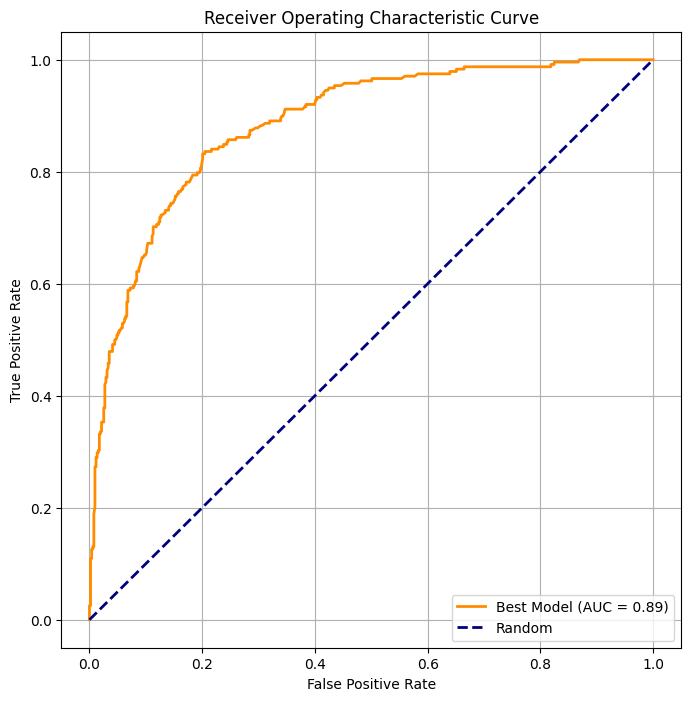

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df['glaucoma'], df['pred_vcdr'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Best Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Best Threshold: 0.62
Accuracy: 0.81
Sensitivity: 0.83
Specificity: 0.80


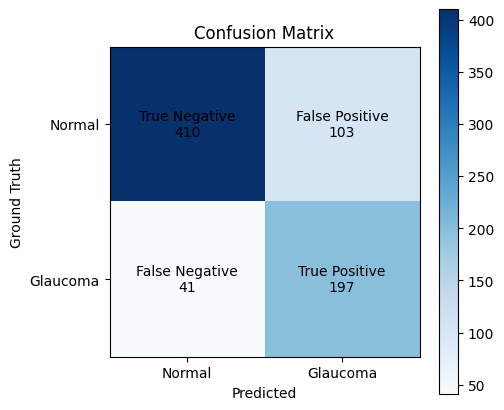

In [11]:
from sklearn.metrics import confusion_matrix

# Find best threshold anc calculate matrix
distances_to_origin = np.sqrt(fpr ** 2 + (1 - tpr) ** 2)
best_threshold = thresholds[np.argmin(distances_to_origin)]
# best_threshold = thresholds[np.argmax(tpr - fpr)]

pred_glaucoma = df['pred_vcdr'] > best_threshold
true_glaucoma = df['glaucoma']

conf_matrix = confusion_matrix(true_glaucoma, pred_glaucoma)
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / len(df)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Glaucoma'])
plt.yticks([0, 1], ['Normal', 'Glaucoma'])
names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{names[i * 2 + j]}\n{conf_matrix[i, j]}', ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

Best Threshold: 0.62
Accuracy: 0.77
Sensitivity: 0.77
Specificity: 0.78


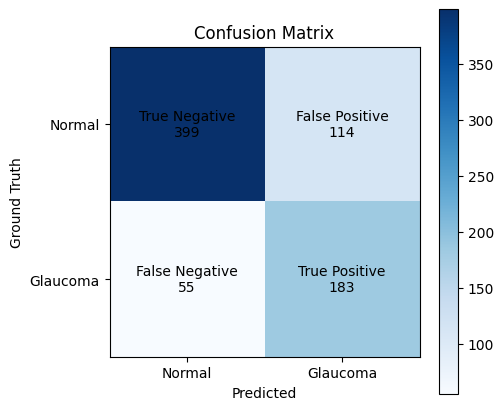

In [12]:
# Find best threshold anc calculate matrix
best_threshold = thresholds[np.argmax(tpr - fpr)]

pred_glaucoma = df['real_vcdr'] > best_threshold
true_glaucoma = df['glaucoma']

conf_matrix = confusion_matrix(true_glaucoma, pred_glaucoma)
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / len(df)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f'Best Threshold: {best_threshold:.2f}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Glaucoma'])
plt.yticks([0, 1], ['Normal', 'Glaucoma'])
names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{names[i * 2 + j]}\n{conf_matrix[i, j]}', ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

MAE: 0.05290242441512516
MSE: 0.004967352715024321
R^2: 0.5485656662606759


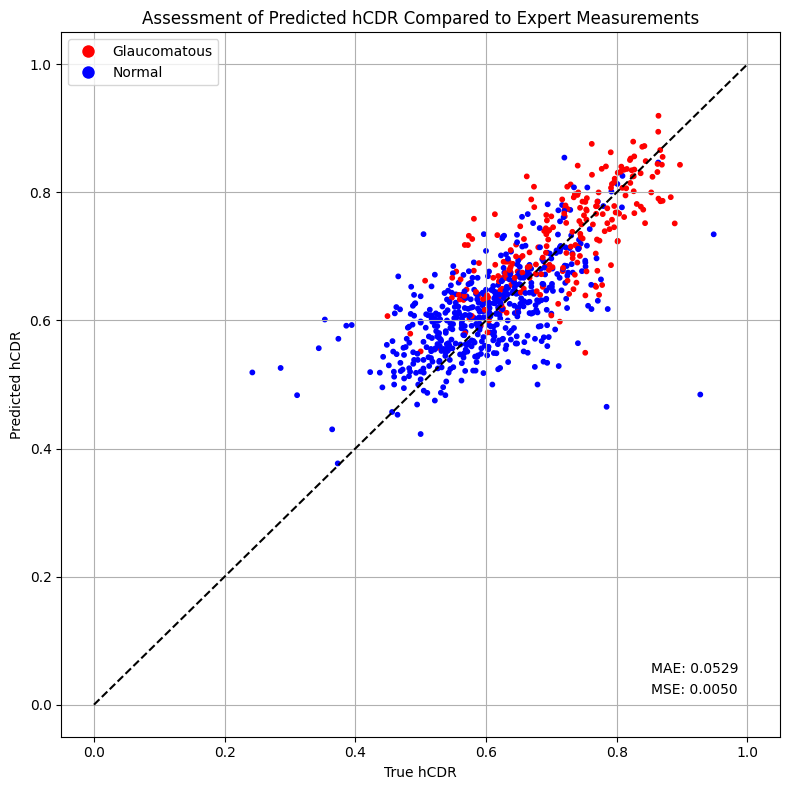

In [13]:
plot_regression(
    df['real_hcdr'], df['pred_hcdr'], df['glaucoma'],
    'Assessment of Predicted hCDR Compared to Expert Measurements',
    'True hCDR', 'Predicted hCDR',
)

MAE: 0.05781269263115405
MSE: 0.006109202846085156
R^2: 0.6997740073066255


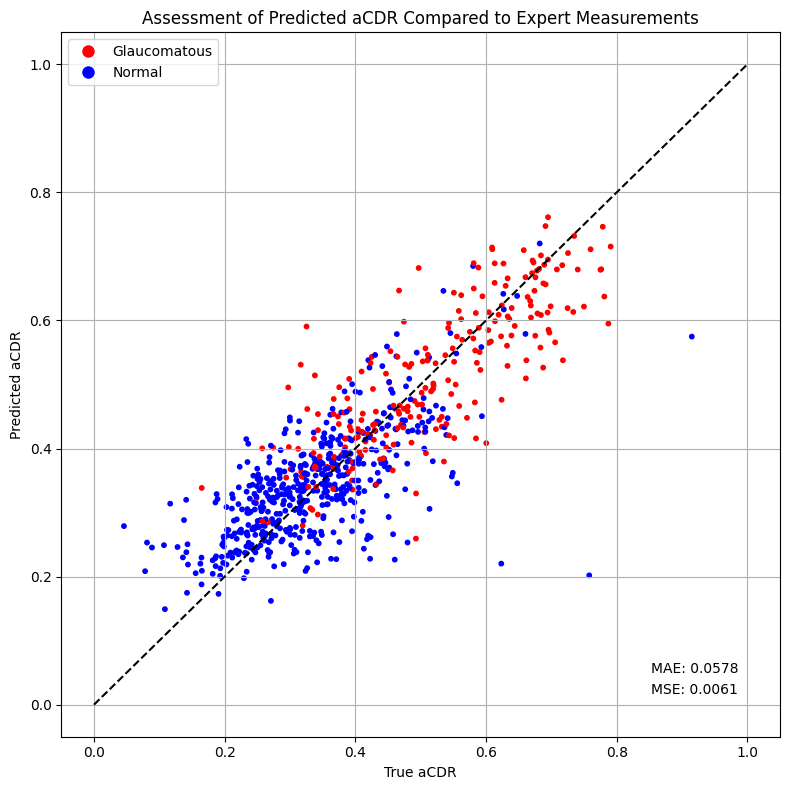

In [14]:
plot_regression(
    df['real_acdr'], df['pred_acdr'], df['glaucoma'],
    'Assessment of Predicted aCDR Compared to Expert Measurements',
    'True aCDR', 'Predicted aCDR',
)

MAE: 3.4354194407456724
MSE: 26.43941411451398
R^2: 0.913974004506878


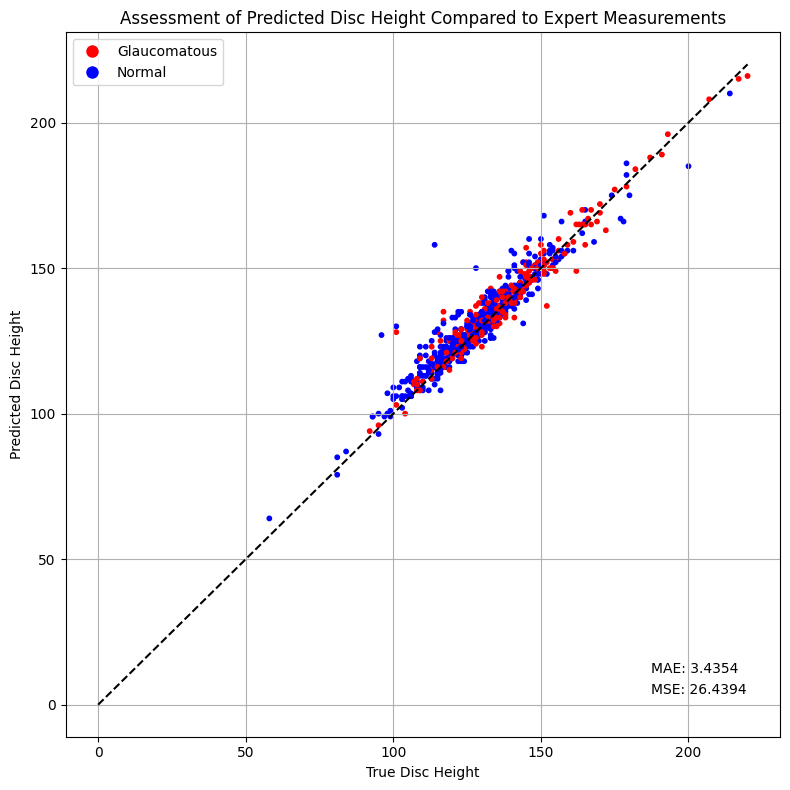

In [15]:
plot_regression(
    df['real_disc_height'], df['pred_disc_height'], df['glaucoma'],
    'Assessment of Predicted Disc Height Compared to Expert Measurements',
    'True Disc Height', 'Predicted Disc Height',
)

MAE: 7.719041278295606
MSE: 107.9960053262317
R^2: 0.7991217274968374


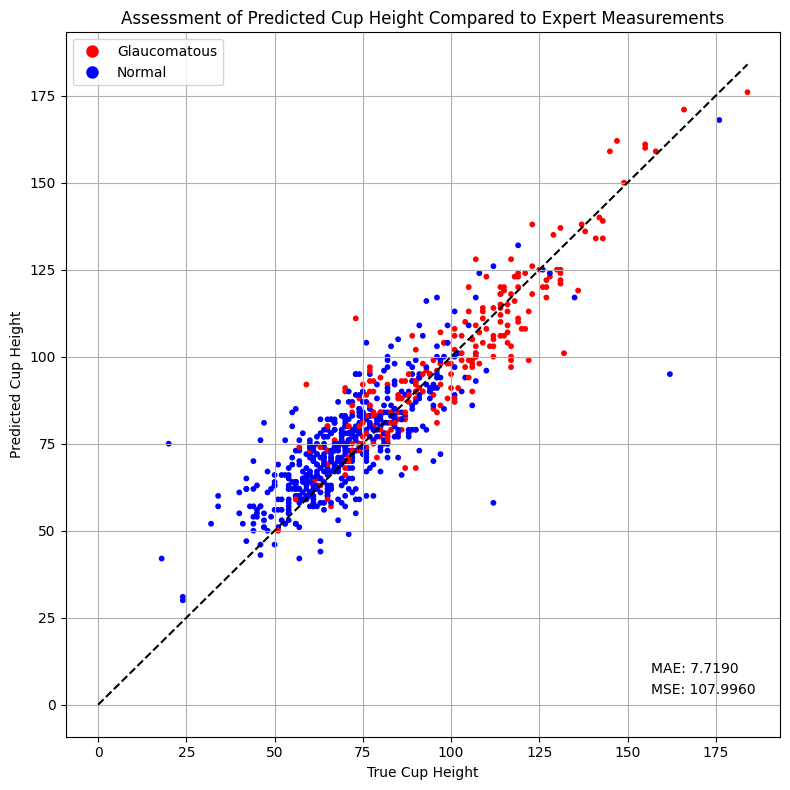

In [16]:
plot_regression(
    df['real_cup_height'], df['pred_cup_height'], df['glaucoma'],
    'Assessment of Predicted Cup Height Compared to Expert Measurements',
    'True Cup Height', 'Predicted Cup Height',
)